# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

trainset = datasets.ImageFolder('./images/train', transform=train_transform)
testset = datasets.ImageFolder('./images/test', transform=test_transform)

#create validation set
trainsetindices = np.array(range(len(trainset)))
np.random.shuffle(trainsetindices)
trainsetsize = int(np.floor(len(trainset) * (1-valid_size)))
trainidx, valididx = trainsetindices[:trainsetsize], trainsetindices[trainsetsize:]

trainsampler = SubsetRandomSampler(trainidx)
validsampler = SubsetRandomSampler(valididx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            sampler=trainsampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            sampler=validsampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         num_workers=num_workers)

loaders_scratch = {'train': trainloader, 'valid': validloader, 'test': testloader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: My code resizes and then crops the images. I picked 224x224 as the size since this is the standard input size for many CNNs (it can be adjusted though). It is a good size that is small enought for the GPU to handle but not too small so that you lose a lot of details.

I have applied random resize crop, random horizontal flip and rotation. In real life images come in different sizes, shapes and orientation.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

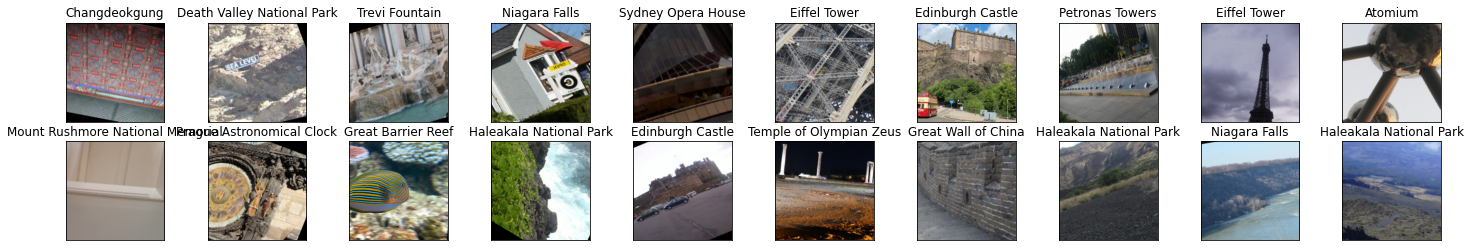

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

#First convert images to numpy arrays
def imconvert(tensor_batch):
    images = []
    for i in range(tensor_batch.size()[0]):
        image = tensor_batch[i].to('cpu').clone().detach()
        image = image.numpy().squeeze()
        image = image.transpose((1,2,0)) #transpose them to the necessary shape
        image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) #unnormalize them
        image = image.clip(0,1)
        images.append(image)
    return images

images, labels = next(iter(trainloader))
images = imconvert(images)

#display 20 pics
fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(images[i])
    ax.set_title(trainset.classes[labels[i]][3:].replace('_', ' '))

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()


def get_optimizer_scratch(model):
    return optim.Adam(model.parameters(), lr=0.001)

num_classes = len(trainset.classes)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64,128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(2,2)
        #ceiling mode will roll the number up
        #self.poolceiling = nn.MaxPool2d(2, 2, ceil_mode= True)

        self.fc1 = nn.Linear(256*7*7, 1000)
        self.fc2 = nn.Linear(1000, num_classes)

        self.dropout = nn.Dropout(0.25)
        
    
    def forward(self, x):
        ## Define forward behavior
        #conv layer 1 sees 224x224x3
        x = self.pool(F.relu(self.conv1(x)))
        #conv layer 2 sees 112x112x16
        x = self.pool(F.relu(self.conv2(x)))        
        #conv layer 3 sees 56x56x32
        x = self.pool(F.relu(self.conv3(x)))         
        #conv layer 4 sees 28x28x64
        x = self.pool(F.relu(self.conv4(x)))
        #conv layer 5 sees 14x14x128
        x = self.pool(F.relu(self.conv5(x)))

        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)   

        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))  
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, we don't apply RELU for that layer
        x = self.fc2(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  First I have created the convolutional layers. There is a pooling layer after each convolutional layer. That way I get a very deep arrays. Pooling layers decrease the size of the each layer. At each step, I have calculated the size of the layers so that I know what is the required input size for the linear classifier layer that comes afterwards.

Then I flatten my tensor before I feed into the classifier network. Here there are only two layers. After the first linear layer is applied, a relu activation function is applied. Afterwards a drop-out layer is applied to prevent overfitting. Then final linear layer is applied. The number of output nodes is 50, since this is the number of classes we have. This result will be directly fed into the cross entropy loss function, so I don't need to get the softmax, it is done automatically.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            #reset the gradients
            optimizer.zero_grad()
            #calculate the results from the model
            output = model(data)
            #calculate the loss
            loss = criterion(output, target)
            #backward pass
            loss.backward()
            #Optimizer step
            optimizer.step()
            #add the average training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)

            loss = criterion(output, target)

            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    #find the linear layers
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    
#-#-# Do NOT modify the code below this line. #-#-#
    
#model_scratch.apply(custom_weight_init)
#model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
#                      criterion_scratch, use_cuda, 'ignore.pt')

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.884010 	Validation Loss: 3.805611
Validation loss decreased (inf --> 3.805611).  Saving model ...
Epoch: 2 	Training Loss: 3.796726 	Validation Loss: 3.764447
Validation loss decreased (3.805611 --> 3.764447).  Saving model ...
Epoch: 3 	Training Loss: 3.763888 	Validation Loss: 3.762923
Validation loss decreased (3.764447 --> 3.762923).  Saving model ...
Epoch: 4 	Training Loss: 3.729527 	Validation Loss: 3.740087
Validation loss decreased (3.762923 --> 3.740087).  Saving model ...
Epoch: 5 	Training Loss: 3.675943 	Validation Loss: 3.695333
Validation loss decreased (3.740087 --> 3.695333).  Saving model ...
Epoch: 6 	Training Loss: 3.615533 	Validation Loss: 3.607667
Validation loss decreased (3.695333 --> 3.607667).  Saving model ...
Epoch: 7 	Training Loss: 3.526305 	Validation Loss: 3.491235
Validation loss decreased (3.607667 --> 3.491235).  Saving model ...


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

trainset = datasets.ImageFolder('./images/train', transform=train_transform)
testset = datasets.ImageFolder('./images/test', transform=test_transform)

#create validation set
trainsetindices = np.array(range(len(trainset)))
np.random.shuffle(trainsetindices)
trainsetsize = int(np.floor(len(trainset) * (1-valid_size)))
trainidx, valididx = trainsetindices[:trainsetsize], trainsetindices[trainsetsize:]

trainsampler = SubsetRandomSampler(trainidx)
validsampler = SubsetRandomSampler(valididx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            sampler=trainsampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            sampler=validsampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         num_workers=num_workers)

loaders_transfer = {'train': trainloader, 'valid': validloader, 'test': testloader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    return optim.Adam(model.parameters(), lr=0.002)


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
from torchvision import models
## TODO: Specify model architecture

#import model
model_transfer = models.densenet121(pretrained=True)
#check the number of inputs

in_features = model_transfer.classifier.in_features

num_classes = len(trainset.classes)

for param in model_transfer.features.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
                        (nn.Linear(in_features, 1000)),
                        (nn.ReLU()),
                        (nn.Linear(1000, 500)),
                        (nn.ReLU()),
                        (nn.Linear(500, num_classes)),
                        )
model_transfer.classifier = classifier

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I have used the densenet as my feature layer. I did this since it is a high performing CNN, works well on images. It is deep enough but not too deep so that it doesn't work on my PC.

I modified the classifying layer. I added 3 layers, last one being the output layer. I apply relu activation function on the first two layers. Last layer is just raw output. Softmax function will be applied by the chosen loss function (Cross entropy loss function)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
def train_transfer(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            #reset the gradients
            optimizer.zero_grad()
            #calculate the results from the model
            output = model(data)
            #calculate the loss
            loss = criterion(output, target)
            #backward pass
            loss.backward()
            #Optimizer step
            optimizer.step()
            #add the average training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)

            loss = criterion(output, target)

            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

#train the model using the above function

num_epochs = 20


# function to re-initialize a model with pytorch's default weight initialization, in case it is necessary to use
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters, if necessary uncomment
#model_transfer.apply(default_weight_init)

# train the model
model_transfer = train_transfer(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer.classifier), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.125013


Test Accuracy: 73% (922/1250)



<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    #import image
    image = Image.open(img_path).convert('RGB')
    #convert to tensor
    image = test_transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    #find the output
    output =  model_transfer(image)
    #convert to numpy then get the ranking order for each item
    if use_cuda:
        output = output.cpu()
    ranking = output.detach().numpy().squeeze(0).argsort()
    landmarks = []
    for i in range(k):
        landmark = trainset.classes[ranking[-i-1]]
        landmark = landmark[3:].replace('_', ' ')
        landmarks.append(landmark)
    
    return landmarks

# test on a sample image
print(predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5))
print(predict_landmarks('images/test/07.Stonehenge/0b9cee1262de75c9.jpg', 5))
print(predict_landmarks('images/test/25.Banff_National_Park/58be13a78fb22d04.jpg', 5))
print(predict_landmarks('images/test/19.Vienna_City_Hall/4cd050d3373538d7.jpg', 5))

['Golden Gate Bridge', 'Brooklyn Bridge', 'Forth Bridge', 'Sydney Opera House', 'Sydney Harbour Bridge']
['Stonehenge', 'Externsteine', 'Machu Picchu', 'Changdeokgung', 'Whitby Abbey']
['Banff National Park', 'Yellowstone National Park', 'Niagara Falls', 'Matterhorn', 'Gullfoss Falls']
['Vienna City Hall', 'Gateway of India', 'Trevi Fountain', 'Edinburgh Castle', 'Whitby Abbey']


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this a picture of the Golden Gate Bridge, Brooklyn Bridge, or Forth Bridge?


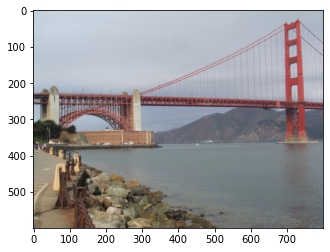

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    text = 'Is this a picture of the ' + predicted_landmarks[0] + ", " + predicted_landmarks[1] + ", or " + predicted_landmarks[2] + "?"
    #import the image as numpy array
    image = cv2.imread(img_path)[...,::-1]
    # display the images
    fig, ax = plt.subplots()
    ax.imshow(image)
    print(text)
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ It is better than I expected. I am surprised with the performance of the function. These models can be improved upon my more modification of the classifying layer and searching for a better CNN that the feature layer we can use for transfer learning. More data can be fed into the models as well. As of now the number of data points is not high enough. Finally I think limited number of landmarks overstate the performance of the model. I would like to see how well it functions when there are a 1000 landmarks but with a lot more images

Is this a picture of the Grand Canyon, Soreq Cave, or Kantanagar Temple?


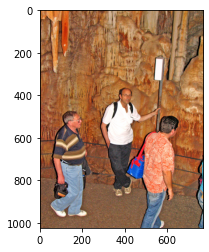

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('imagesmyown/soreq.jpg')


Is this a picture of the Gullfoss Falls, Niagara Falls, or Yellowstone National Park?


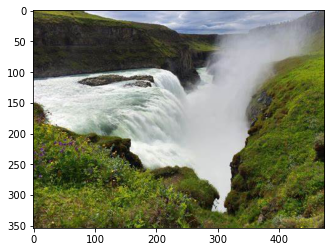

In [ ]:
suggest_locations('imagesmyown/gulfoss.jpg')

Is this a picture of the Changdeokgung, Temple of Heaven, or Central Park?


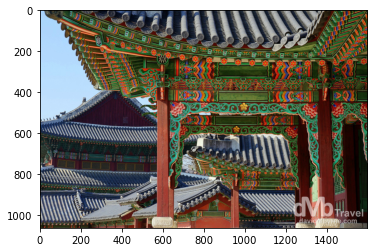

In [ ]:
suggest_locations('imagesmyown/Changdeokgung.jpg')

Is this a picture of the Trevi Fountain, Vienna City Hall, or Temple of Olympian Zeus?


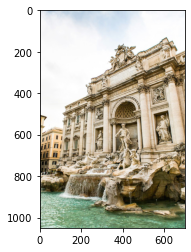

In [ ]:
suggest_locations('imagesmyown/trevi.jpg')